In [1]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adagrad
from tqdm import tqdm
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
import random
from collections import defaultdict
import warnings
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import re
import bisect
import shutil
import json
from time import perf_counter

# warnings.filterwarnings("ignore")

from IPython.display import HTML
import os
import pickle
from sentence_transformers import SentenceTransformer
import av
from transformers import VideoLlavaForConditionalGeneration, VideoLlavaProcessor
from huggingface_hub import hf_hub_download


/home/jamesdin/miniconda3/envs/videollava/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


### Error Analysis

In [2]:

load_in_bits = 4
device = 'cuda'
compute_dtype = 'fp16'
double_quant = True
quant_type = 'nf4'

compute_dtype = (torch.float16 if compute_dtype == 'fp16' else (torch.bfloat16 if compute_dtype == 'bf16' else torch.float32))

bnb_model_from_pretrained_args = {}
if load_in_bits in [4, 8]:
    from transformers import BitsAndBytesConfig
    bnb_model_from_pretrained_args.update(dict(
        device_map={"": device},
        # load_in_4bit=load_in_bits == 4,
        # load_in_8bit=load_in_bits == 8,
        quantization_config=BitsAndBytesConfig(
            load_in_4bit=load_in_bits == 4,
            load_in_8bit=load_in_bits == 8,
            llm_int8_skip_modules=["mm_projector"],
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
            bnb_4bit_compute_dtype=compute_dtype,
            bnb_4bit_use_double_quant=double_quant,
            bnb_4bit_quant_type=quant_type # {'fp4', 'nf4'}
        )
    ))

model = VideoLlavaForConditionalGeneration.from_pretrained(
    "LanguageBind/Video-LLaVA-7B-hf",
    torch_dtype=compute_dtype,
    attn_implementation="flash_attention_2",
    **bnb_model_from_pretrained_args
)

processor = VideoLlavaProcessor.from_pretrained("LanguageBind/Video-LLaVA-7B-hf")


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
from IPython.display import HTML
import base64

def display_video_embed(video_id, video_dir="/data/user_data/jamesdin/STAR/data/Charades_v1_480"):
    video_path = os.path.join(video_dir, f"{video_id}.mp4")

    print("Embedding video:", video_path)
    
    with open(video_path, "rb") as f:
        video_encoded = base64.b64encode(f.read()).decode("utf-8")
    
    html = f'''
    <video width="320" height="240" controls>
        <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    '''
    
    return HTML(html)

from IPython.display import HTML
import base64
import os
import subprocess

def display_video_clip(video_id, start_sec, end_sec, video_dir="/data/user_data/jamesdin/STAR/data/Charades_v1_480"):
    video_path = os.path.join(video_dir, f"{video_id}.mp4")
    output_path = f"/tmp/{video_id}_{start_sec}_{end_sec}.mp4"

    # Extract clip using ffmpeg
    cmd = [
        "ffmpeg",
        "-ss", str(start_sec),
        "-to", str(end_sec),
        "-i", video_path,
        "-c:v", "libx264",
        "-an",
        "-y",  # overwrite
        output_path
    ]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    with open(output_path, "rb") as f:
        video_encoded = base64.b64encode(f.read()).decode("utf-8")

    html = f'''
    <video width="400" height="300" controls>
        <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    '''
    return HTML(html)


import matplotlib.pyplot as plt

def display_sampled_frames(video_frames, frame_ids=None, title="Sampled Video Frames"):
    num_frames = len(video_frames)
    plt.figure(figsize=(15, 2))
    for i, frame in enumerate(video_frames):
        plt.subplot(1, num_frames, i + 1)
        plt.imshow(frame)
        if frame_ids is not None:
            plt.title(f"ID: {frame_ids[i]}")
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


In [12]:
import pickle
import pandas as pd

# Load the .pkl file
with open('/data/user_data/jamesdin/STAR/data/STAR_val.pkl', 'rb') as f:
    data = pickle.load(f)

# Convert to DataFrame and set index
df = pd.DataFrame(data).set_index('question_id')



In [13]:
df

,question,video_id,start,end,answer,question_program,choices,situations
question_id,,,,,,,,
Interaction_T1_13,Which object was tidied up by the person?,6H78U,11.1,19.6,The clothes.,"[{'function': 'Situations', 'value_input': []}...","[{'choice_id': 0, 'choice': 'The closet/cabine...","{'000206': {'rel_pairs': [['o000', 'o027'], ['..."
Interaction_T1_14,Which object was tidied up by the person?,6H78U,15.6,22.7,The clothes.,"[{'function': 'Situations', 'value_input': []}...","[{'choice_id': 0, 'choice': 'The blanket.', 'c...","{'000289': {'rel_pairs': [['o000', 'o027'], ['..."
Interaction_T1_31,Which object was thrown by the person?,RNLTR,7.3,13.5,The clothes.,"[{'function': 'Situations', 'value_input': []}...","[{'choice_id': 0, 'choice': 'The pillow.', 'ch...","{'000132': {'rel_pairs': [['o000', 'o019'], ['..."
Interaction_T1_32,Which object was put down by the person?,RNLTR,11.6,16.4,The shoe.,"[{'function': 'Situations', 'value_input': []}...","[{'choice_id': 0, 'choice': 'The food.', 'choi...","{'000202': {'rel_pairs': [['o000', 'o019'], ['..."
Interaction_T1_40,Which object was tidied up by the person?,VNQTH,2.7,9.2,The closet/cabinet.,"[{'function': 'Situations', 'value_input': []}...","[{'choice_id': 0, 'choice': 'The broom.', 'cho...","{'000110': {'rel_pairs': [['o000', 'o014'], ['..."
...,...,...,...,...,...,...,...,...
Feasibility_T6_1453,What is the person able to do after taking the...,L9ANI,7.3,12.9,Wash the table.,"[{'function': 'Situations', 'value_input': []}...","[{'choice_id': 0, 'choice': 'Wash the table.',...","{'000227': {'rel_pairs': [['o000', 'o006'], ['..."
Feasibility_T6_1454,What is the person able to do after walking th...,L9ANI,0.0,4.1,Take the towel.,"[{'function': 'Situations', 'value_input': []}...","[{'choice_id': 0, 'choice': 'Take the towel.',...","{'000033': {'rel_pairs': [['o000', 'o006']], '..."
Feasibility_T6_1455,What is the person able to do after walking th...,L9ANI,0.0,4.1,Wash the table.,"[{'function': 'Situations', 'value_input': []}...","[{'choice_id': 0, 'choice': 'Throw the bag.', ...","{'000033': {'rel_pairs': [['o000', 'o006']], '..."


In [6]:
import pandas as pd

# result_file = "analysis/video_llava_cot_results.jsonl"

result_file = "analysis/video_llava_vot_results.jsonl"

# result_file = "analysis/video_llava_4_frames_results.jsonl"


# Read .jsonl file into a DataFrame
result_df = pd.read_json(result_file, lines=True)

# Optional: set index to question_id
result_df.set_index("question_id", inplace=True)

# Display the first few rows
result_df


,question,choices,pred_ans_idx,true_index,category,raw_response,prompt,frame_ids,inference_time,data_time,confidence,logits,targets,object_descriptions,action_analysis,scores
question_id,,,,,,,,,,,,,,,,
Sequence_T3_4045,What happened after the person opened the door?,"[[Took the phone/camera.], [Closed the closet/...",0,0,Sequence,[Took the phone/camera.],,"[120, 164, 209, 253, 298, 342, 387, 432]",14.889332,703627.678408,"[[7.042540914881101e-07, 2.424348224394634e-07...","[[3.82421875, 2.7578125, 2.587890625, 3.037109...",The key targets to track in the video are the ...,"After the person opened the door, they picked ...","In the video, a person is seen holding an oran...","[8/10, 8/10, 5, 8/10]"
Prediction_T3_1155,Which object would the person open next?,"[[The box.], [The bag.], [The laptop.], [The b...",0,3,Prediction,[The box.],,"[72, 102, 133, 164, 195, 226, 257, 288]",25.069594,703629.365953,"[[4.7136666125879845e-07, 2.498524622751574e-0...","[[3.806640625, 3.171875, 2.947265625, 3.181640...",The key targets to track in the video are the ...,The person holding the bottle of water is like...,"In the video, a person is holding a bottle of ...","[5, 5, 5, 5]"
Sequence_T5_1092,What did the person do to the towel after clos...,"[[Tidied up.], [Put down.], [Threw.], [Took.]]",4,3,Sequence,None,,"[272, 291, 310, 330, 349, 369, 388, 408]",34.320519,703616.200689,"[[4.404202798014012e-07, 1.648947716148541e-07...","[[3.560546875, 2.578125, 2.240234375, 2.720703...",The key targets in the video are the person ho...,The person in the video is holding a towel and...,"In the video, a person is seen holding a towel...","[5/10\nThe answer is plausible, but it is not ..."
Sequence_T6_3309,What did the person do to the box before watch...,"[[Took.], [Threw.], [Closed.], [Put down.]]",0,3,Sequence,[Took.],,"[60, 182, 305, 428, 551, 674, 797, 920]",26.399327,703630.857543,"[[4.315872388360731e-07, 2.397457592451246e-07...","[[3.052734375, 2.46484375, 2.19921875, 2.69531...","The key targets in the video are the person, t...",The person in the video is seen standing in fr...,"In the video, a person is seen standing in fro...","[9/10, 9/10, 9/10, 9/10]"
Sequence_T1_5848,Which object did the person open after they cl...,"[[The refrigerator.], [The door.], [The window...",3,0,Sequence,[The closet/cabinet.],,"[336, 390, 445, 499, 554, 608, 663, 718]",28.482154,703618.580524,"[[7.29998930637521e-07, 2.808905321671773e-07,...","[[3.8515625, 2.896484375, 2.572265625, 3.88867...","The key targets in the video are the person, t...",The person in the video is a man wearing a gra...,"In the video, a man wearing a gray sweater and...","[9/10, 9/10, 8/10, 9/10]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sequence_T6_4075,What did the person do to the closet/cabinet b...,"[[Tidied up.], [Opened.], [Washed.], [Closed.]]",0,3,Sequence,[Tidied up.],,"[690, 724, 758, 792, 827, 861, 895, 930]",24.887198,724009.753279,"[[3.764604059597332e-07, 1.926530615037336e-07...","[[3.314453125, 2.64453125, 2.009765625, 3.0078...",The key targets in the video are the person ho...,The person holding the dish is standing in fro...,"In the video, a person is standing in front of...","[9/10, 9/10, 9/10, 9/10]"
Sequence_T3_6165,What happened after the person took the cup/gl...,"[[Tidied up the table.], [Put down the phone/c...",0,0,Sequence,[Tidied up the table.],,"[840, 878, 916, 955, 993, 1032, 1070, 1109]",47.966037,724043.682691,"[[5.760797421316965e-07, 1.7986087641475018e-0...","[[3.33203125, 2.16796875, 1.8935546875, 2.4414...",The key targets to track in the video are the ...,"In the video, a person is seen holding a cup/g...","In the video, a person is holding a cup/glass/...","[5/10\nThe answer is plausible, but it is not ..."
Interaction_T2_3755,What did the person do with the closet/cabinet?,"[[Threw.], [Opened.], [Closed.], [Tidied up.]]",1,2,Interaction,[Opened.],,"[240, 265, 291, 317, 342, 368, 394, 420]",27.160732,724090.118106,"[[6

In [7]:

def read_video_pyav(container, indices):
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])

def read_video_pyav2(video_path, start, end, num_frames=8):
        """Reads a video for given start-end timestamps interval and uniformly samples 8 frames of it"""
        container = av.open(video_path)
        video = container.streams.get(0)[0]

        av_timestamps = [
            int(packet.pts * video.time_base)
            for packet in container.demux(video)
            if packet.pts is not None
        ]

        av_timestamps.sort()
        start_id = bisect.bisect_left(av_timestamps, start)
        end_id = bisect.bisect_left(av_timestamps, end)

        # in case it is a very short video, lets take a longer duration and sample
        if end_id - start_id < 10:
            end_id += 10
            start_id -= 10

        end_id = min(len(av_timestamps) - 1, end_id)
        start_id = max(1, start_id)

        # We sample 8 frames for tuning following the original paper
        # But we can increase the number of frames for longer videos and check out if it helps performance
        # Change the below "8" to any number of frames you want, and note that more frames -> more computational resources needed
        indices = np.linspace(start_id, end_id, num_frames).astype(int)

        frames = []
        container.seek(0)
        for i, frame in enumerate(container.decode(video=0)):
            if i > end_id:
                break
            if i >= start_id and i in indices:
                frames.append(frame)
        assert (
            len(frames) == num_frames
        ), f"Got {len(frames)} frames but should be {num_frames}. Check the indices: {indices};, start_id: {start_id}, end_id: {end_id}. Len of video is {len(av_timestamps)} frames."
        return np.stack([x.to_ndarray(format="rgb24") for x in frames]), indices


def print_error_analysis(row):
    print("="*80)
    print(f"Question ID   : {row.name}")
    print(f"Category      : {row['category']}")
    print(f"Question      : {row['question']}")
    print("Choices       :")
    for i, choice in enumerate(row['choices']):
        print(f"  {i+1}. {choice}")
    print(f"\nPredicted     : {row['pred_ans_idx'] + 1}. {row['choices'][row['pred_ans_idx']]}")
    print(f"Ground Truth  : {row['true_index'] + 1}. {row['choices'][row['true_index']]}")
    print(f"\nConfidence    : {['{:.4f}'.format(c) for c in row['confidence']]}")
    print(f"Logits        : {['{:.4f}'.format(l) for l in row['logits']]}")
    print(f"Frame IDs     : {row['frame_ids']}")
    print(f"Inference Time: {row['inference_time']:.2f}s")
    print("\nRaw Response  :")
    print(row['raw_response'].strip())
    print("="*80)


def print_vot_analysis(row):
    print("="*100)
    print(f"Question ID       : {row.name}")
    print(f"Category          : {row['category']}")
    print(f"Question          : {row['question']}\n")

    print("Choices:")
    for i, choice in enumerate(row['choices']):
        print(f"  {i+1}. {choice[0]}")

    pred_idx = row['pred_ans_idx']
    true_idx = row['true_index']

    print(f"\nPredicted Answer  : {pred_idx + 1}. {row['choices'][pred_idx][0]}")
    print(f"Ground Truth      : {true_idx + 1}. {row['choices'][true_idx][0]}")

    # Handle possible nested list formats for confidence/logits
    conf = row['confidence'][0] if isinstance(row['confidence'][0], list) else row['confidence']
    logi = row['logits'][0] if isinstance(row['logits'][0], list) else row['logits']

    print(f"\nFrame IDs         : {row['frame_ids']}")
    print(f"Inference Time    : {row['inference_time']:.2f}s")
    print(f"Confidence Scores : {[f'{c:.4f}' for c in conf]}")
    print(f"Logits            : {[f'{l:.4f}' for l in logi]}")
    print(f"Scores (Rating)   : {row['scores']}\n")

    print("Targets:")
    print(row['targets'].strip() if isinstance(row['targets'], str) else "")
    print("\nObject Descriptions:")
    print(row['object_descriptions'].strip() if isinstance(row['object_descriptions'], str) else "")
    print("\nAction Analysis:")
    print(row['action_analysis'].strip() if isinstance(row['action_analysis'], str) else "")
    print("\nRaw Model Response:")
    print(row['raw_response'].strip() if isinstance(row['raw_response'], str) else "")
    print("="*100)

# Example usage:
# print_vot_analysis(df.loc["Interaction_T1_4197"])


In [8]:
question_id = 'Interaction_T1_4197'

result_item = result_df.loc[question_id]
example = df.loc[question_id]

video_id = example['video_id']
question = example['question']
choices = [x['choice'] for x in example['choices']]
start = example['start']
end = example['end']
start, end

(26.8, 33.3)

In [9]:
# sample uniformly 8 frames from the video

video_path = f"/data/user_data/jamesdin/STAR/data/Charades_v1_480/{video_id}.mp4"

container = av.open(video_path)
# total_frames = container.streams.video[0].frames
# indices = np.arange(0, total_frames, total_frames / 8).astype(int)

selected_frame_ids = result_item['frame_ids']
selected_video_frames = read_video_pyav(container, selected_frame_ids)

# total_frames = 8
# video_frames, frame_idx = read_video_pyav2(video_path, start, end, num_frames=total_frames)


In [10]:
# display_video_embed(video_id)

display_video_clip(video_id=video_id, start_sec=start, end_sec=end)


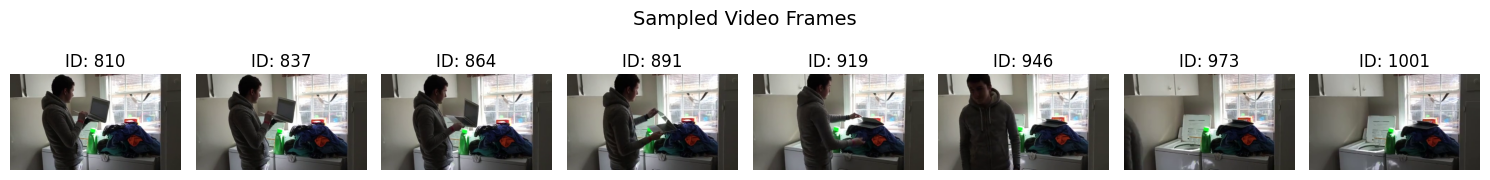

In [11]:
display_sampled_frames(selected_video_frames, selected_frame_ids)

In [12]:
print(f"Question: {question}")
print(f"Choices: {choices}")

Question: Which object was put down by the person?
Choices: ['The phone/camera.', 'The laptop.', 'The blanket.', 'The clothes.']


In [13]:
# print_error_analysis(result_item)

In [14]:
print_vot_analysis(result_item)

Question ID       : Interaction_T1_4197
Category          : Interaction
Question          : Which object was put down by the person?

Choices:
  1. The phone/camera.
  2. The laptop.
  3. The blanket.
  4. The clothes.

Predicted Answer  : 4. The clothes.
Ground Truth      : 2. The laptop.

Frame IDs         : [810, 837, 864, 891, 919, 946, 973, 1001]
Inference Time    : 14.27s
Confidence Scores : ['0.0000', '0.0000', '0.0000', '0.0000']
Logits            : ['3.6875', '3.0703', '2.8691', '3.7812']
Scores (Rating)   : ['9/10', '9/10', '9/10', '9/10']

Targets:
The key targets to track in the video are the person, the washing machine, and the clothes. The person is seen putting down a bottle of detergent on the washing machine, so the washing machine and the clothes are the objects that need to be tracked to answer the question.

Object Descriptions:
The person is wearing a grey sweater and is standing in front of the washing machine. They are holding a bottle of detergent and are in the

### Quantatively Analysis

In [30]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
import pickle
import pandas as pd

# Load the .pkl file
with open('/data/user_data/jamesdin/STAR/data/STAR_val.pkl', 'rb') as f:
    data = pickle.load(f)

# Convert to DataFrame and set index
df = pd.DataFrame(data).set_index('question_id')


In [32]:
cot_result_path = "analysis/video_llava_cot_results.jsonl"
vot_result_path = "analysis/video_llava_vot_results.jsonl"
base_result_path = "analysis/results/video_llava_results_8f.jsonl"

# Load JSONL files into DataFrames
df_base = pd.read_json("analysis/results/video_llava_results_8f.jsonl", lines=True).set_index('question_id')
df_cot = pd.read_json("analysis/video_llava_cot_results.jsonl", lines=True).set_index('question_id')
df_vot = pd.read_json("analysis/video_llava_vot_results.jsonl", lines=True).set_index('question_id')

/tmp/ipykernel_1045071/196441436.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('category').apply(lambda x: (x['pred_ans_idx'] == x['true_index']).mean())
/tmp/ipykernel_1045071/196441436.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('category').apply(lambda x: (x['pred_ans_idx'] == x['true_index']).mean())
/tmp/ipykernel_1045071/196441436.py:7: DeprecationWarn

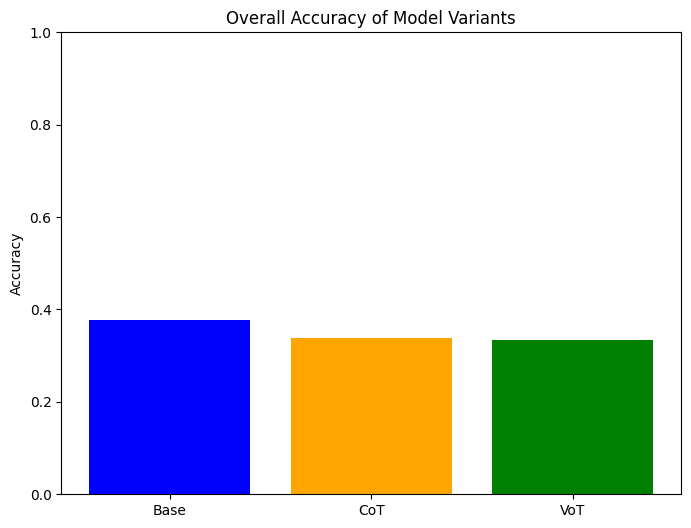

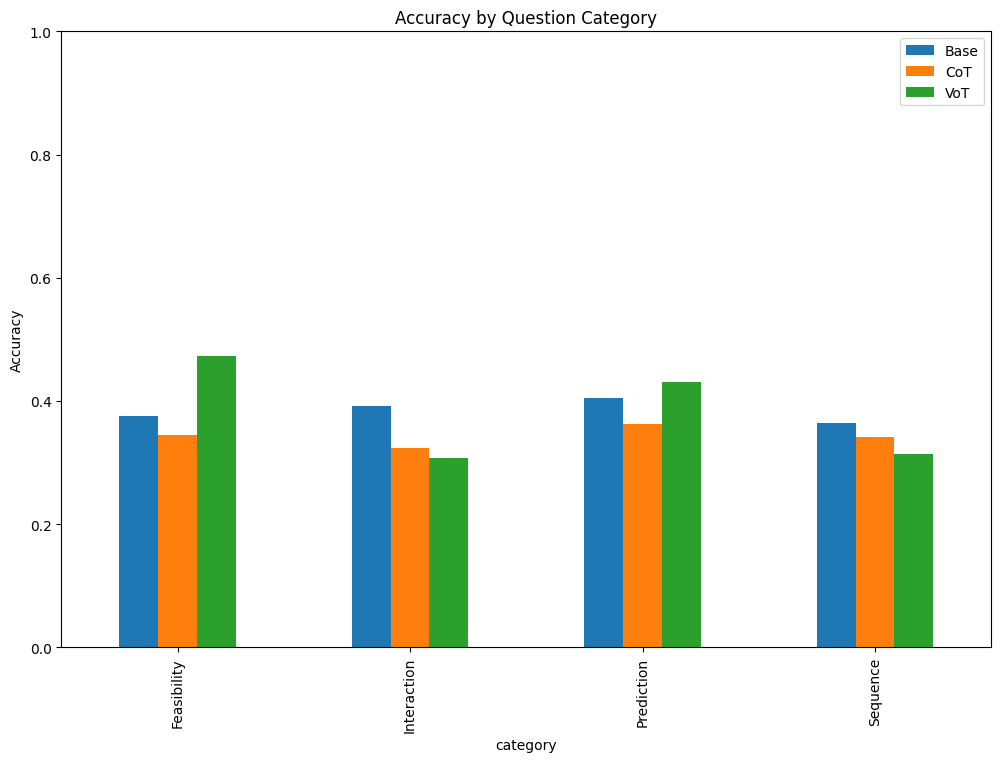

In [33]:

# Function to calculate accuracy
def calculate_accuracy(df):
    return (df['pred_ans_idx'] == df['true_index']).mean()

# Function to calculate accuracy by category
def accuracy_by_category(df):
    return df.groupby('category').apply(lambda x: (x['pred_ans_idx'] == x['true_index']).mean())

# Calculate overall accuracy
accuracy_base = calculate_accuracy(df_base)
accuracy_cot = calculate_accuracy(df_cot)
accuracy_vot = calculate_accuracy(df_vot)

# Calculate accuracy by category
accuracy_base_by_cat = accuracy_by_category(df_base)
accuracy_cot_by_cat = accuracy_by_category(df_cot)
accuracy_vot_by_cat = accuracy_by_category(df_vot)

# Combine accuracy by category into a single DataFrame
accuracy_by_cat_df = pd.DataFrame({
    'Base': accuracy_base_by_cat,
    'CoT': accuracy_cot_by_cat,
    'VoT': accuracy_vot_by_cat
}).reset_index()

# Plot overall accuracy
plt.figure(figsize=(8, 6))
plt.bar(['Base', 'CoT', 'VoT'], [accuracy_base, accuracy_cot, accuracy_vot], color=['blue', 'orange', 'green'])
plt.ylabel('Accuracy')
plt.title('Overall Accuracy of Model Variants')
plt.ylim(0, 1)
plt.show()

# Plot accuracy by category
accuracy_by_cat_df.set_index('category').plot(kind='bar', figsize=(12, 8))
plt.ylabel('Accuracy')
plt.title('Accuracy by Question Category')
plt.ylim(0, 1)
plt.show()

/tmp/ipykernel_1045071/2903974370.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  overall_accuracy = df_all.groupby("model").apply(lambda x: (x["pred_ans_idx"] == x["true_index"]).mean()).reset_index(name="accuracy")
/tmp/ipykernel_1045071/2903974370.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_category = df_all.groupby(["model", "category"]).apply(lambda x: (x["pred_ans_idx"] == x[

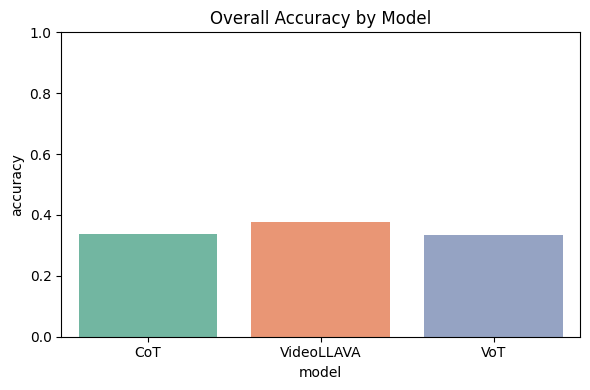

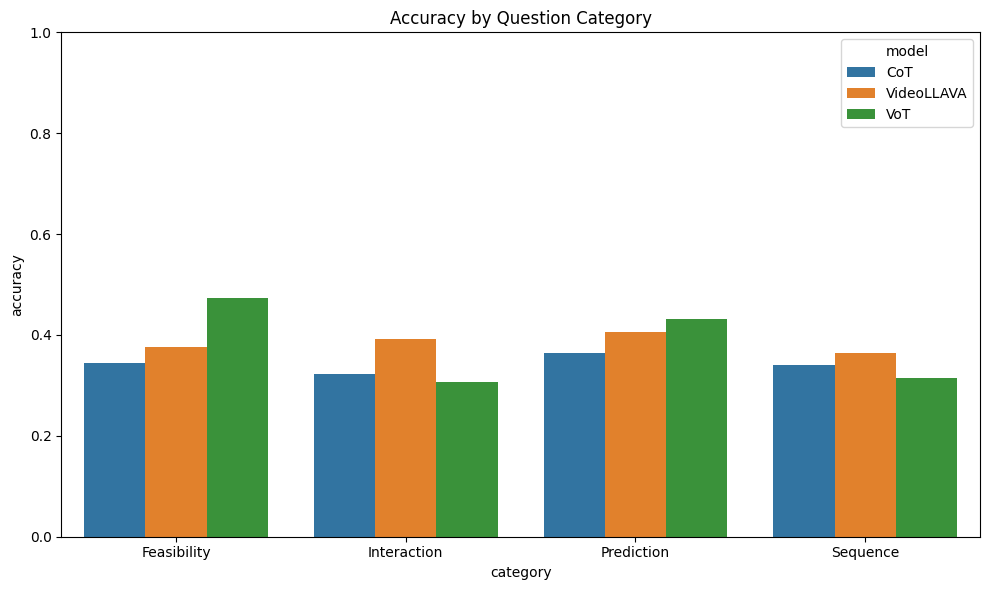

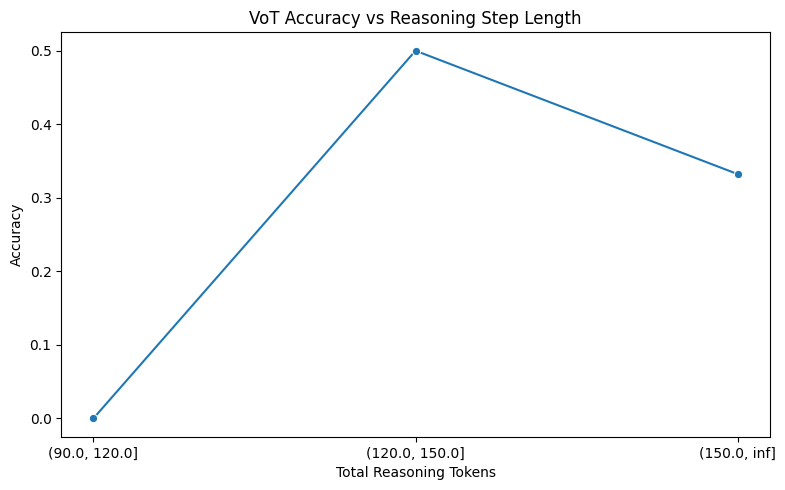

/tmp/ipykernel_1045071/2903974370.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_inference_time, x="model", y="avg_inference_time", palette="pastel")


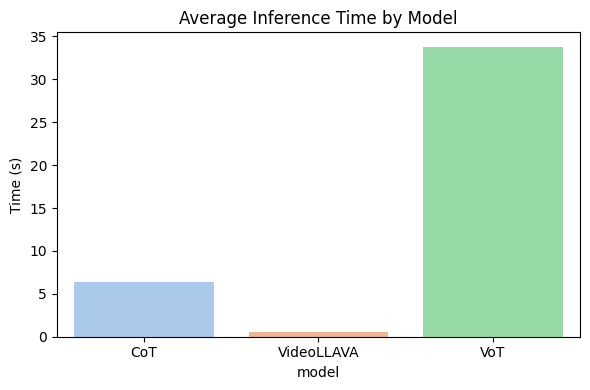

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Mark the source for comparison
df_base["model"] = "VideoLLAVA"
df_cot["model"] = "CoT"
df_vot["model"] = "VoT"

# Combine all into one DataFrame for comparison
df_all = pd.concat([df_base, df_cot, df_vot], ignore_index=True)

# Compute overall accuracy
overall_accuracy = df_all.groupby("model").apply(lambda x: (x["pred_ans_idx"] == x["true_index"]).mean()).reset_index(name="accuracy")

# Compute accuracy by category
accuracy_by_category = df_all.groupby(["model", "category"]).apply(lambda x: (x["pred_ans_idx"] == x["true_index"]).mean()).reset_index(name="accuracy")

# Compute average inference time per model
avg_inference_time = df_all.groupby("model")["inference_time"].mean().reset_index(name="avg_inference_time")

# Prepare reasoning step length statistics for VoT
df_vot["total_reasoning_tokens"] = df_vot[["targets", "object_descriptions", "action_analysis"]].apply(lambda x: sum(len(str(s).split()) for s in x), axis=1)
df_vot["correct"] = df_vot["pred_ans_idx"] == df_vot["true_index"]

# Accuracy vs. reasoning length
bins = pd.cut(df_vot["total_reasoning_tokens"], bins=[0, 30, 60, 90, 120, 150, float("inf")])
length_acc = df_vot.groupby(bins).apply(lambda x: (x["pred_ans_idx"] == x["true_index"]).mean()).reset_index(name="accuracy")
length_acc["tokens_range"] = length_acc["total_reasoning_tokens"].astype(str)

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot: Overall Accuracy
plt.figure(figsize=(6, 4))
sns.barplot(data=overall_accuracy, x="model", y="accuracy", palette="Set2")
plt.title("Overall Accuracy by Model")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Bar plot: Accuracy by Category
plt.figure(figsize=(10, 6))
sns.barplot(data=accuracy_by_category, x="category", y="accuracy", hue="model")
plt.title("Accuracy by Question Category")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Line plot: Reasoning Length vs Accuracy for VoT
plt.figure(figsize=(8, 5))
sns.lineplot(data=length_acc, x="tokens_range", y="accuracy", marker="o")
plt.title("VoT Accuracy vs Reasoning Step Length")
plt.ylabel("Accuracy")
plt.xlabel("Total Reasoning Tokens")
plt.tight_layout()
plt.show()

# Visualize average inference time
plt.figure(figsize=(6, 4))
sns.barplot(data=avg_inference_time, x="model", y="avg_inference_time", palette="pastel")
plt.title("Average Inference Time by Model")
plt.ylabel("Time (s)")
plt.tight_layout()
plt.show()


/tmp/ipykernel_1045071/1088681636.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


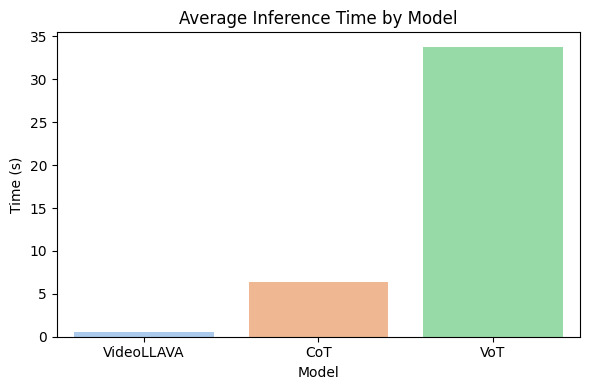

In [46]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=avg_inference_time,
    x="model",
    y="avg_inference_time",
    palette="pastel",
    order=["VideoLLAVA", "CoT", "VoT"]  # specify desired order here
)
plt.title("Average Inference Time by Model")
plt.ylabel("Time (s)")
plt.xlabel("Model")
plt.tight_layout()
plt.show()


In [35]:
df.loc['Interaction_T1_13']['situations']['000206']

{'rel_pairs': [['o000', 'o027'],
  ['o000', 'o019'],
  ['o000', 'o004'],
  ['o000', 'o004']],
 'rel_labels': ['r002', 'r002', 'r002', 'r003'],
 'actions': ['a004', 'a002', 'a056'],
 'bbox': [[167.51, 317.98, 226.33, 331.49],
  [140.16, 268.79, 211.72, 323.48],
  [162.93, 298.17, 228.31, 331.25]],
 'bbox_labels': ['o027', 'o019', 'o004']}

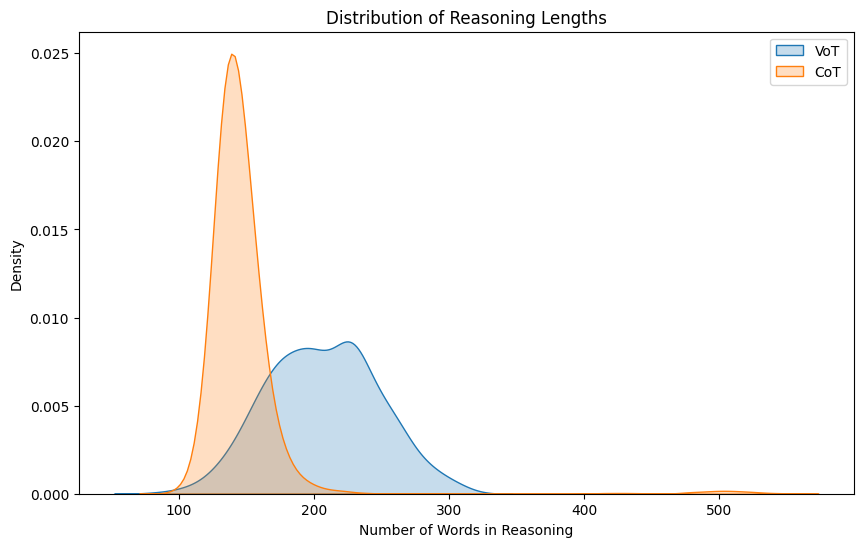

/tmp/ipykernel_1045071/919257392.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby('length_group')['true_index'].apply(lambda x: (x == df.loc[x.index]['pred_ans_idx']).mean())
/tmp/ipykernel_1045071/919257392.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby('length_group')['true_index'].apply(lambda x: (x == df.loc[x.index]['pred_ans_idx']).mean())


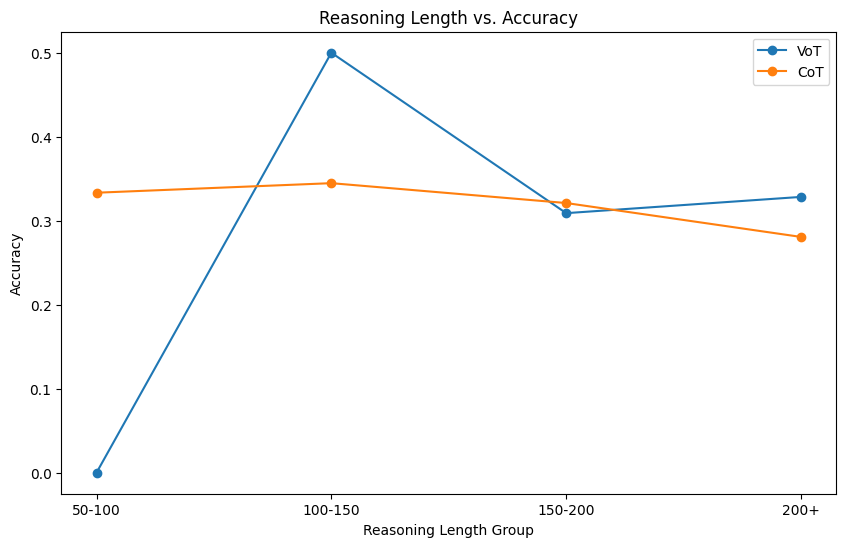

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

# 1. Distribution of Reasoning Length for VoT and CoT
def get_reasoning_length(df):
    """Calculate reasoning length for both VoT and CoT models"""
    df = df.copy()
    if 'object_descriptions' in df.columns:  # VoT format
        df['reasoning_length'] = (df['object_descriptions'].str.split().str.len() + 
                                 df['action_analysis'].str.split().str.len())
    else:  # CoT format
        df['reasoning_length'] = df['raw_response'].str.split().str.len()
    return df

df_vot = get_reasoning_length(df_vot)
df_cot = get_reasoning_length(df_cot)

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_vot['reasoning_length'], label='VoT', fill=True)
sns.kdeplot(data=df_cot['reasoning_length'], label='CoT', fill=True)
plt.title('Distribution of Reasoning Lengths')
plt.xlabel('Number of Words in Reasoning')
plt.ylabel('Density')
plt.legend()
plt.show()

# 2. Reasoning Length vs. Accuracy
def length_vs_accuracy(df):
    bins = [0, 50, 100, 150, 200, np.inf]
    labels = ['<50', '50-100', '100-150', '150-200', '200+']
    df['length_group'] = pd.cut(df['reasoning_length'], bins=bins, labels=labels)
    return df.groupby('length_group')['true_index'].apply(lambda x: (x == df.loc[x.index]['pred_ans_idx']).mean())

plt.figure(figsize=(10, 6))
plt.plot(length_vs_accuracy(df_vot), marker='o', label='VoT')
plt.plot(length_vs_accuracy(df_cot), marker='o', label='CoT')
plt.title('Reasoning Length vs. Accuracy')
plt.xlabel('Reasoning Length Group')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



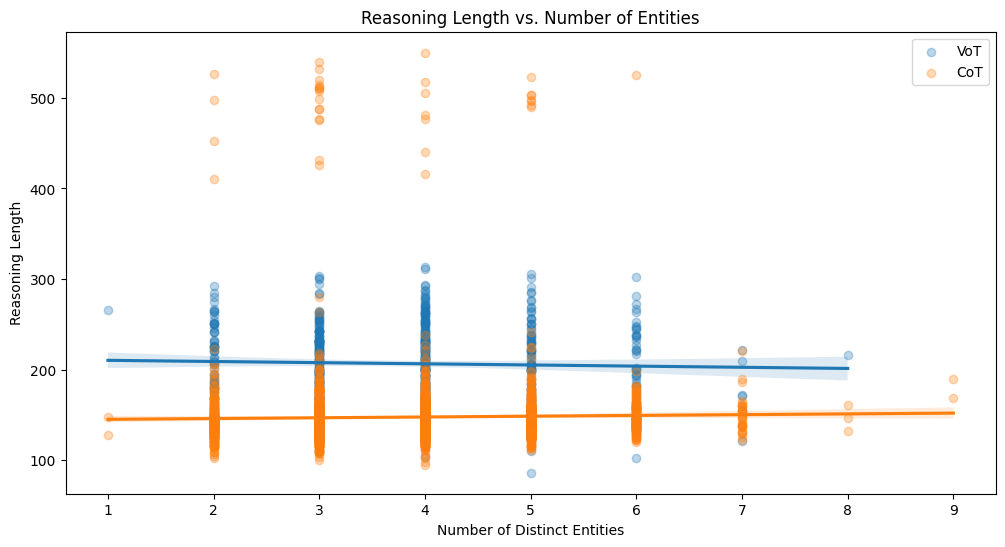

In [37]:
# 3. Hypergraph Complexity Calculations (REVISED)
def compute_hypergraph_complexity(df):
    """Calculate complexity metrics and merge back to main DF"""
    complexities = []
    for idx, row in df.iterrows():
        num_entities = 0
        num_edges = 0
        if isinstance(row['situations'], dict):  # Handle potential NaNs
            for frame in row['situations'].values():
                num_entities = max(num_entities, len(frame.get('bbox_labels', [])))
                num_edges += len(frame.get('rel_pairs', []))
        complexities.append({'num_entities': num_entities, 'num_edges': num_edges})
    
    return pd.DataFrame(complexities, index=df.index)

# Apply to original metadata dataframe and merge
df_hyper = compute_hypergraph_complexity(df)
df_vot_w_hyper = df_vot.merge(df_hyper, left_index=True, right_index=True)
df_cot_w_hyper = df_cot.merge(df_hyper, left_index=True, right_index=True)

# 4. Reasoning Length vs. Question Difficulties (FIXED)
plt.figure(figsize=(12, 6))

# VoT
sns.regplot(
    x=df_vot_w_hyper['num_entities'], 
    y=df_vot_w_hyper['reasoning_length'], 
    label='VoT',
    scatter_kws={'alpha': 0.3}
)

# CoT
sns.regplot(
    x=df_cot_w_hyper['num_entities'], 
    y=df_cot_w_hyper['reasoning_length'], 
    label='CoT',
    scatter_kws={'alpha': 0.3}
)

plt.title('Reasoning Length vs. Number of Entities')
plt.xlabel('Number of Distinct Entities')
plt.ylabel('Reasoning Length')
plt.legend()
plt.show()

In [38]:
# First, ensure all models have hypergraph complexity data
def add_complexity_to_models(metadata_df, *model_dfs):
    """Add complexity metrics to all model dataframes"""
    # Compute complexity for all questions in metadata
    df_hyper = compute_hypergraph_complexity(metadata_df)
    
    # Merge complexity data into each model DF
    enhanced_dfs = []
    for df in model_dfs:
        enhanced = df.merge(
            df_hyper,
            left_on='question_id', 
            right_index=True,
            how='left'
        )
        enhanced_dfs.append(enhanced)
    
    return enhanced_dfs

# Apply to all models (assuming original df is your metadata)
df_base_enh, df_cot_enh, df_vot_enh = add_complexity_to_models(df, df_base, df_cot, df_vot)


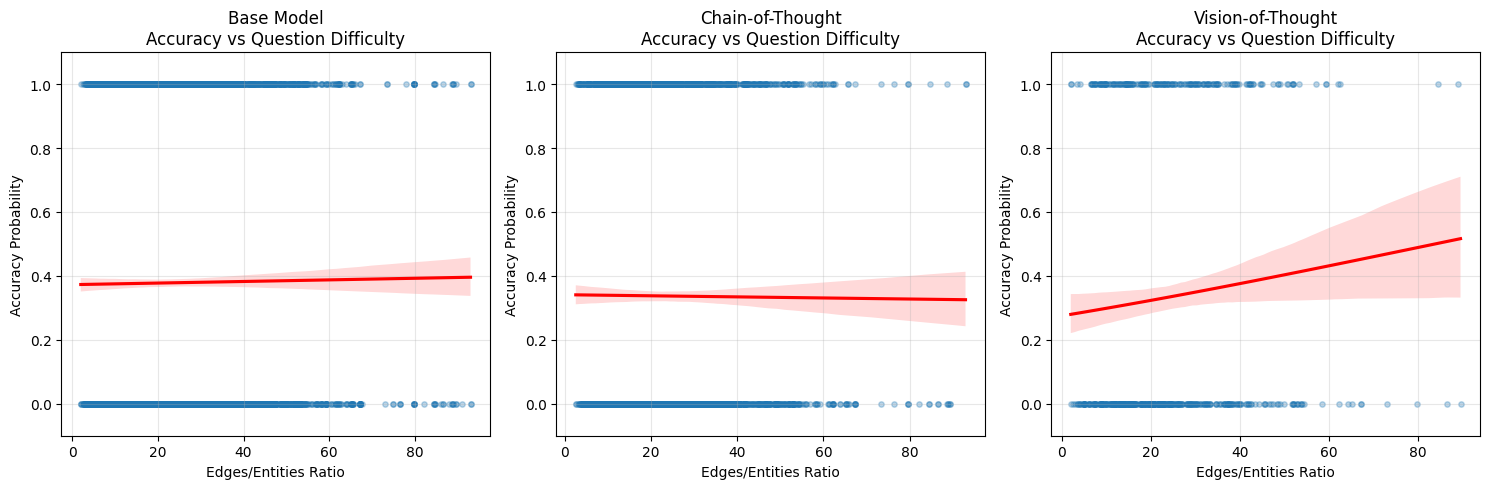

In [40]:

# Now create visualizations for each model
plt.figure(figsize=(15, 5))

for idx, (model_df, model_name) in enumerate(zip(
    [df_base_enh, df_cot_enh, df_vot_enh],
    ['Base Model', 'Chain-of-Thought', 'Vision-of-Thought']
), 1):
    # Calculate difficulty metric
    model_df = model_df.dropna(subset=['num_edges', 'num_entities'])
    model_df['difficulty'] = model_df['num_edges'] / (model_df['num_entities'] + 1e-9)  # Prevent division by zero
    
    # Create correct flag
    model_df['correct'] = (model_df['pred_ans_idx'] == model_df['true_index']).astype(int)
    
    # Plot
    plt.subplot(1, 3, idx)
    sns.regplot(
        x='difficulty',
        y='correct',
        data=model_df,
        logistic=True,
        scatter_kws={'alpha': 0.3, 's': 15},
        line_kws={'color': 'red'}
    )
    plt.title(f'{model_name}\nAccuracy vs Question Difficulty')
    plt.xlabel('Edges/Entities Ratio')
    plt.ylabel('Accuracy Probability')
    plt.ylim(-0.1, 1.1)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()